In [1]:
# Setup (Imports)

from sklearn.utils import shuffle

from datetime import datetime, timedelta
import numpy as np
import os

import matplotlib.pyplot as plt

In [2]:
# Load CSV

def csv_as_numpy(stock):
    """
    Loads csv file as a np array
    
    CSV -> 2d [samples, features]
    """
    days, day_values = [], []
    
    with open(os.path.join('data', stock + '.csv'), 'r') as data:

        for line in data:

            if len(line) > 6 and "Date" not in line and "null" not in line:

                items = line.split(",")
                
                days.append(items[0])
                day_values.append( np.array( list(map(float, items[1:])) ) )
                
    return days, np.array(day_values) # dates, 2d array

def headline_word2vec_csv_as_numpy(stock, emb_size=100, sentence_length=12):
    """
    Loads csv file as a np array
    
    CSV -> 3d [samples, wordlen, wordvec]
    """
    days, day_values = [], []
    
    with open(os.path.join('data', stock + '-headlines-vectors.csv'), 'r') as data:

        for line in data:

            if len(line) > 6:

                day, uneven_vector = line[:10], line[11:]
                
                uneven_vector = np.array(eval(uneven_vector))
                
                even_vector = np.zeros((sentence_length, emb_size))
                even_vector[:uneven_vector.shape[0], :] = uneven_vector[:sentence_length, :]
                
                days.append(day)
                day_values.append(even_vector)
                
    return days, np.array(day_values)

def headline_doc2vec_csv_as_numpy(stock):
    """
    Loads csv file as a np array
    
    CSV -> 2d [samples, doc2vec]
    """
    days, day_values = [], []
    
    with open(os.path.join('data', stock + '-headlines-vectors.csv'), 'r') as data:

        for line in data:

            if len(line) > 6:

                day, vector = line[:10], line[11:]
                
                vector = np.array(eval(vector))
                
                days.append(day)
                day_values.append(vector)
                
    return days, np.array(day_values)


In [3]:
# Make Data

def create_timeframed_close_regression_data(stock, window_size, window_skip=0, norm=False):
    """
    Timeframe Close Regression
    
    Creates data for a close-only based price regression from last `window_size` days
    """
    data = csv_as_numpy(stock)[1][:, 3]
    
    X, Y = [], []
    
    for i in range(len(data) - window_size - 1):
        
        time_frame = np.copy(data[i: i + window_size + 1])

        if norm:
            
            time_frame -= np.mean(time_frame[:-1])
            time_frame /= np.std(time_frame)
            
        X.append(time_frame[:-1 - window_skip])
        Y.append(time_frame[-1])
        
    return np.array(X), np.array(Y)

def create_timeframed_alldata_classification_data(stock, window_size, norm=True, output='up/down'):
    """
    Timeframe Alldata Classification
    
    Creates data for prediction of stock up/down from all stock features for given `window_size`
    """
    data = csv_as_numpy(stock)[1][:, (0,1,2,4,5)] # OPEN HIGH LOW close ADJ_CLOSE VOLUME
    
    X, Y = [], []
    
    for i in range(1, len(data) - window_size - 1):
        
        time_frame = np.copy(data[i: i + window_size + 1])
        
        current_close = time_frame[-1, 3]
        last_close = time_frame[-2, 3]

        if norm:
            
            time_frame -= np.mean(time_frame[:-1], axis=0)
            time_frame /= np.std(time_frame[:-1], axis=0)
            
        X.append(time_frame[:-1])
        
        if output == 'up/down':
            
            if last_close < current_close:
            
                Y.append([1., 0.])
                
            else:
                
                Y.append([0., 1.])
                
        elif output == '+-1':

            if last_close < current_close:
            
                Y.append(+1.)
                
            else:
                
                Y.append(-1.)
        
    return np.array(X), np.array(Y)

def create_timeframed_word2vec_classification_data(stock, window_size):
    
    days1, histstock_data = csv_as_numpy(stock)
    days2, headlines_data = headline_word2vec_csv_as_numpy(stock)
    
    histstock_data = histstock_data[:, 4] # Close
    
    X, Y = [], []
    
    for i in range(1, len(headlines_data) - window_size - 1):
    
        headline_timeframe = np.copy(headlines_data[i: i + window_size])
        
        window_end_date = days2[i + window_size]
        
        try:
            
            histstock_index = days1.index(window_end_date)
        
            last_close = histstock_data[histstock_index]
            current_close = histstock_data[histstock_index + 1]
        
            if last_close < current_close:
            
                Y.append([1., 0.])
                
            else:
                
                Y.append([0., 1.])
                
            X.append(headline_timeframe)
                
        except (ValueError, IndexError):
            
            pass
            
    return np.array(X), np.array(Y)

def create_timeframed_doc2vec_classification_data(stock, window_size, norm=True):
    
    days1, histstock_data = csv_as_numpy(stock)
    days2, headlines_data = headline_doc2vec_csv_as_numpy(stock)
    
    histstock_data = histstock_data[:, 4] # Close
    
    X, Y = [], []
    
    for i in range(1, len(headlines_data) - window_size - 1):
    
        headline_timeframe = np.copy(headlines_data[i: i + window_size])
        
        window_end_date = days2[i + window_size]
        
        end_date = datetime(int(window_end_date[:4]), int(window_end_date[5:7]), int(window_end_date[8:]))
        
        try:
            
            delta = 0
            
            while not end_date.strftime('%Y-%m-%d') in days1 and delta < 5:
                
                end_date = end_date + timedelta(days=1)
                
                delta += 1
                
            if delta >= 5:
                
                continue
            
            histstock_index = days1.index(end_date.strftime('%Y-%m-%d'))
            
            if histstock_index + 1 >= len(histstock_data):
                
                continue
        
            last_close = histstock_data[histstock_index]
            current_close = histstock_data[histstock_index + 1]
        
            if last_close < current_close:
            
                Y.append([1., 0.])
                
            else:
                
                Y.append([0., 1.])
                
            if norm:
                
                headline_timeframe -= np.mean(headline_timeframe)
                headline_timeframe /= np.std(headline_timeframe)
                
            X.append(headline_timeframe)
                
        except (ValueError, IndexError):
            
            pass
            
    return np.array(X), np.array(Y)


In [4]:
# Split Data

def split_data(X, Y, ratio=.8, mix=True):
    """
    Splits X/Y to Train/Test
    """
    train_size = int(len(X) * ratio)
    
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]
    
    if mix:
        
        trainX, trainY = shuffle(trainX, trainY, random_state=0)
    
    return trainX, trainY, testX, testY


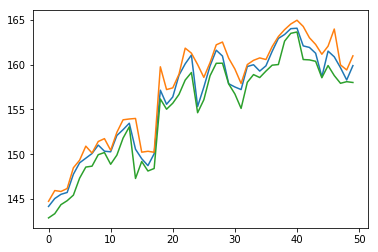

In [5]:
# Run (Test)

if __name__ == "__main__":
    
    closing = []
    
    high, low = [], []

    for values in csv_as_numpy('AAPL')[1]:

        closing.append(values[3])
        high.append(values[1])
        low.append(values[2])

    plt.plot(closing[-50:])
    plt.plot(high[-50:])
    plt.plot(low[-50:])
    plt.show()